# 🧬 Genetic Algorithm – Function Optimization

This notebook implements a simple **Genetic Algorithm (GA)** to minimize the following test function:

\begin{equation}
f(x) = 1.5-\exp \left\{-x_1^2-x_2^2\right\}-0.5 \exp \left\{-\left(x_1-1\right)^2-\left(x_2+2\right)^2\right\}
\end{equation}



In [30]:
import numpy as np
import matplotlib.pyplot as plt
import random

## 🔧 Helper Function: Normalization


In [31]:
def min_max_norm(val, min_val, max_val, new_min, new_max):
  return (val - min_val) * (new_max - new_min) / (max_val - min_val) + new_min

## 🧬 `Chromosome` Class
Represents a single solution encoded as a bit string.  
It contains the following methods:
- `decode` – decodes a segment of the chromosome into a real value within the search space,  
- `mutation` – mutates a random gene with a given probability,  
- `crossover` – performs one-point crossover with another chromosome.  


In [32]:
class Chromosome:
  def __init__(self, length, array=None):
    self.array = array if array is not None else [random.randint(0, 1) for _ in range(length)]

  def decode(self, lower_bound, upper_bound, aoi):
    new_array = self.array[ lower_bound : upper_bound + 1 ]
    value = int( "".join( map( str, new_array ) ), 2 )
    max_value = 2 ** ( len( new_array ) ) - 1
    return(min_max_norm( value, 0, max_value, aoi[0], aoi[1] ))

  def mutation(self, probability):
    if random.random() <= probability:
      mutated_index = random.randint ( 0, len(self.array) - 1)
      self.array[ mutated_index ] ^= 1

  def crossover(self, other):
    cross_point = random.randint( 1, len(self.array)-1 )
    child1 = Chromosome( length = len(self.array), array = self.array[:cross_point] + other.array[cross_point:])
    child2 = Chromosome( length = len(self.array), array = other.array[:cross_point] + self.array[cross_point:])
    return child1, child2

## ⚙️ `GeneticAlgorithm` Class

This class implements the **Genetic Algorithm (GA)** workflow for function optimization.  

### Key parameters:
- **chromosome_length** – total number of bits in each chromosome,  
- **obj_func_num_args** – number of arguments in the objective function,  
- **objective_function** – the function to optimize,  
- **aoi** – area of interest (search space) for each argument,  
- **population_size** – number of individuals in the population,  
- **tournament_size** – number of individuals competing in tournament selection,  
- **mutation_probability** – probability of a bit flip mutation,  
- **crossover_probability** – probability of performing crossover,  
- **num_steps** – number of generations to run.  

### Main methods:
- `initialize_population()` – creates the initial random population,  
- `eval_objective_func(chromosome)` – evaluates the objective function for a chromosome,  
- `tournament_selection()` – selects the best chromosome from a random tournament,  
- `reproduce(parents)` – applies crossover and mutation to generate offspring,  
- `plot_func(trace)` – visualizes the contour of the function and GA search path,  
- `run()` – runs the GA loop (selection → crossover/mutation → evaluation) and returns the best solution.  


In [33]:
class GeneticAlgorithm:
  def __init__(self, chromosome_length, obj_func_num_args, objective_function, aoi, population_size=1000,
               tournament_size=2, mutation_probability=0.05, crossover_probability=0.8, num_steps=30):
    assert chromosome_length % obj_func_num_args == 0, "Number of bits for each argument should be equal"
    self.chromosome_lengths = chromosome_length
    self.obj_func_num_args = obj_func_num_args
    self.bits_per_arg = int(chromosome_length / obj_func_num_args)
    self.objective_function = objective_function
    self.aoi = aoi
    self.tournament_size = tournament_size
    self.mutation_probability = mutation_probability
    self.crossover_probability = crossover_probability
    self.num_steps = num_steps
    self.population = []
    self.population_size = population_size
    self.initialize_population()

  def initialize_population(self):
    self.population = []
    for i in range(self.population_size):
      self.population.append(Chromosome(self.chromosome_lengths))

  def eval_objective_func(self, chromosome):
    decoded_args = []
    for i in range(self.obj_func_num_args):
      start = i * self.bits_per_arg
      end = start + self.bits_per_arg - 1
      decoded_args.append(chromosome.decode(start, end, self.aoi))
    func_value = self.objective_function(*decoded_args)
    return {tuple(decoded_args): func_value}


  def tournament_selection(self):
    tournament = random.sample(self.population, self.tournament_size)
    tournament_values = [(chromosome, self.eval_objective_func(chromosome)) for chromosome in tournament]
    best_chromosome = min(tournament_values, key=lambda x: list(x[1].values())[0])[0]
    return best_chromosome

  def reproduce(self, parents):
    parent_1, parent_2 = parents
    if random.random() <= self.crossover_probability:
      child_1, child_2 = parent_1.crossover(parent_2)
    else:
      child_1, child_2 = parent_1, parent_2
    child_1.mutation(self.mutation_probability)
    child_2.mutation(self.mutation_probability)
    return child_1, child_2

  def plot_func(self, trace):
    X = np.arange(-2, 3, 0.05)
    Y = np.arange(-4, 2, 0.05)
    X, Y = np.meshgrid(X, Y)
    Z = 1.5 - np.exp(-X ** (2) - Y ** (2)) - 0.5 * np.exp(-(X - 1) ** (2) - (Y + 2) ** (2))
    plt.figure()
    plt.contour(X, Y, Z, 10)
    cmaps = [[ii / len(trace), 0, 0] for ii in range(len(trace))]
    plt.scatter([x[0] for x in trace], [x[1] for x in trace], c=cmaps)
    plt.show()

  def run(self):
    best_solution = None
    best_solution_value = float('inf')
    best_args = []
    trace = []
    for step in range(self.num_steps):
      new_population = []
      for j in range(self.population_size // 2):
        parents = [self.tournament_selection() for x in range(2)]
        child_1, child_2 = self.reproduce(parents)
        new_population.extend([child_1, child_2])
      self.population = new_population
      for chromosome in self.population:
       result = self.eval_objective_func(chromosome)
       value = list(result.values())[0]
       decoded_args = list(result.keys())[0]
       if value < best_solution_value:
         best_solution = chromosome
         best_solution_value = value
         best_args = decoded_args
         trace.append(decoded_args)
      #print(f"Step {step + 1}, Min Value: {best_solution_value}")
    self.plot_func(trace)
    return best_solution, best_solution_value, trace, best_args

def sample_objective_function(x1, x2):
    result = 1.5 - np.exp(-x1**2 - x2**2) - 0.5 * np.exp(-(x1 - 1)**2 - (x2 + 2)**2)
    return result

## 🔬 Experiments with Different GA Parameters

In this section we run the **Genetic Algorithm** with different settings:
- Chromosome length
- Population size
- Tournament size  
- Mutation probability  
- Crossover probability
- Number of generations

This helps to analyze how the parameters influence the convergence of the algorithm.


In [34]:
def run_test(chromosome_length, population_size, tournament_size, mutation_probability, crossover_probability, num_steps):
    ga = GeneticAlgorithm(
        chromosome_length=chromosome_length,
        obj_func_num_args=2,
        objective_function=sample_objective_function,
        aoi=[-3, 3],
        population_size=population_size,
        tournament_size=tournament_size,
        mutation_probability=mutation_probability,
        crossover_probability=crossover_probability,
        num_steps=num_steps
    )

    best_solution, best_value, trace, best_args = ga.run()
    print("=== Test Run ===")
    print(f"Chromosome length: {chromosome_length}")
    print(f"Population size: {population_size}")
    print(f"Tournament size: {tournament_size}")
    print(f"Mutation probability: {mutation_probability}")
    print(f"Crossover probability: {crossover_probability}")
    print(f"Generations: {num_steps}")
    print(f"Best decoded solution (x,y): {best_args}")
    print(f"Best value: {best_value:.6f}")
    print()


### 🔬 Experiment 1: Chromosome Length

The chromosome length determines the **number of bits per variable**.  
- Longer chromosomes = higher precision (but larger search space).  
- Shorter chromosomes = lower precision (faster search, but less accurate).


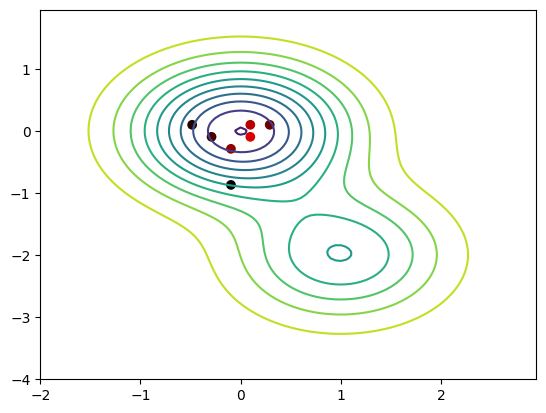

=== Test Run ===
Chromosome length: 10
Population size: 200
Tournament size: 2
Mutation probability: 0.05
Crossover probability: 0.8
Generations: 50
Best decoded solution (x,y): (0.09677419354838701, -0.09677419354838701)
Best value: 0.512647



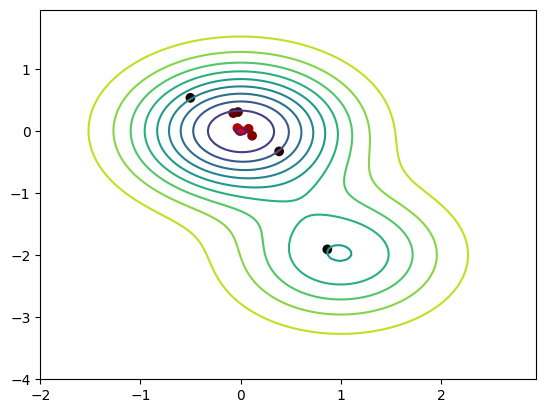

=== Test Run ===
Chromosome length: 20
Population size: 200
Tournament size: 2
Mutation probability: 0.05
Crossover probability: 0.8
Generations: 50
Best decoded solution (x,y): (0.0029325513196480912, 0.0029325513196480912)
Best value: 0.496668



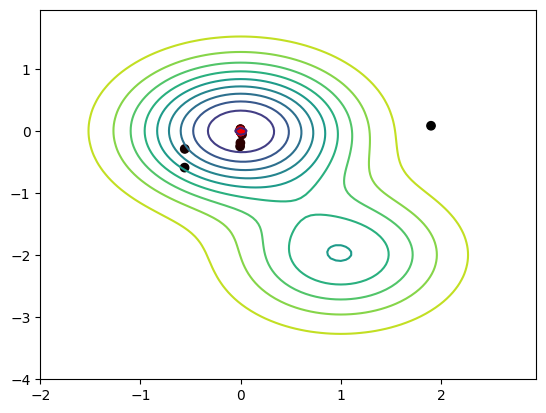

=== Test Run ===
Chromosome length: 30
Population size: 200
Tournament size: 2
Mutation probability: 0.05
Crossover probability: 0.8
Generations: 50
Best decoded solution (x,y): (-9.155552842798897e-05, -0.006866664632099173)
Best value: 0.496585



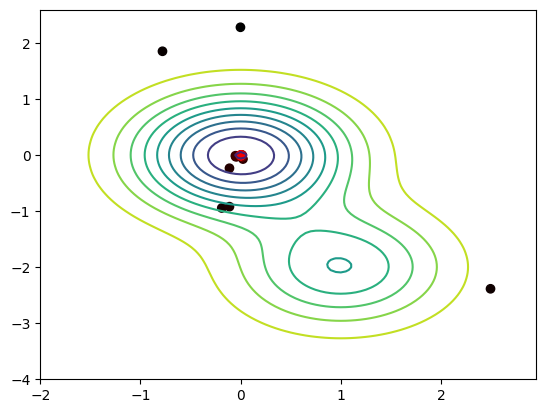

=== Test Run ===
Chromosome length: 40
Population size: 200
Tournament size: 2
Mutation probability: 0.05
Crossover probability: 0.8
Generations: 50
Best decoded solution (x,y): (0.0034990344038337007, -0.006960875473857264)
Best value: 0.496572



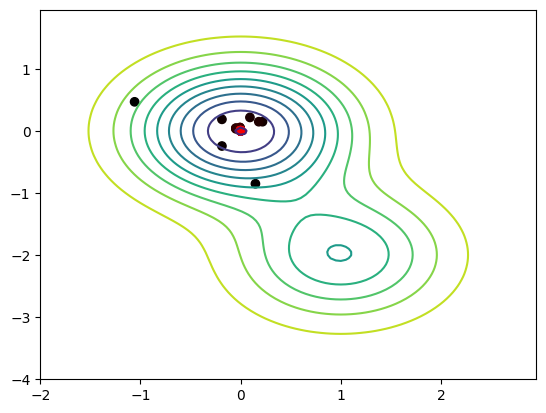

=== Test Run ===
Chromosome length: 100
Population size: 200
Tournament size: 2
Mutation probability: 0.05
Crossover probability: 0.8
Generations: 50
Best decoded solution (x,y): (-4.591051068647545e-05, 5.833663347054596e-06)
Best value: 0.496631



In [35]:
for length in [10, 20, 30, 40, 100]:
    run_test(chromosome_length=length, population_size=200, tournament_size=2,
             mutation_probability=0.05, crossover_probability=0.8, num_steps=50)


### 🔬 Experiment 2: Population Size

The population size controls **diversity of solutions**:
- Small population = faster but risk of premature convergence,  
- Large population = more exploration but higher computational cost.


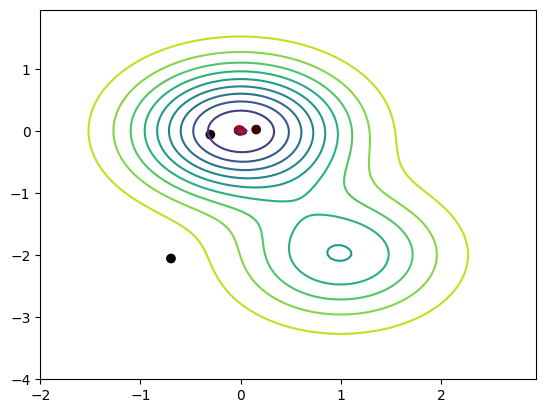

=== Test Run ===
Chromosome length: 20
Population size: 50
Tournament size: 2
Mutation probability: 0.05
Crossover probability: 0.8
Generations: 50
Best decoded solution (x,y): (-0.0029325513196480912, 0.0029325513196480912)
Best value: 0.496707



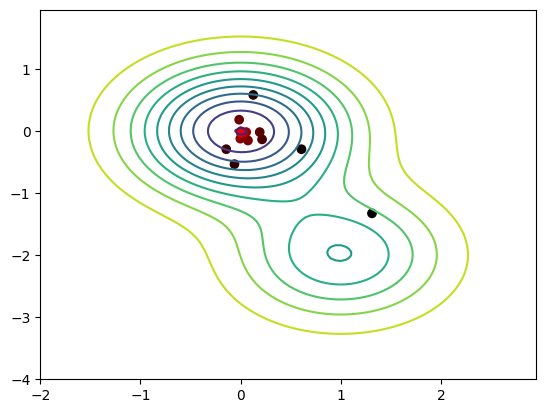

=== Test Run ===
Chromosome length: 20
Population size: 100
Tournament size: 2
Mutation probability: 0.05
Crossover probability: 0.8
Generations: 50
Best decoded solution (x,y): (0.0029325513196480912, -0.008797653958944274)
Best value: 0.496576



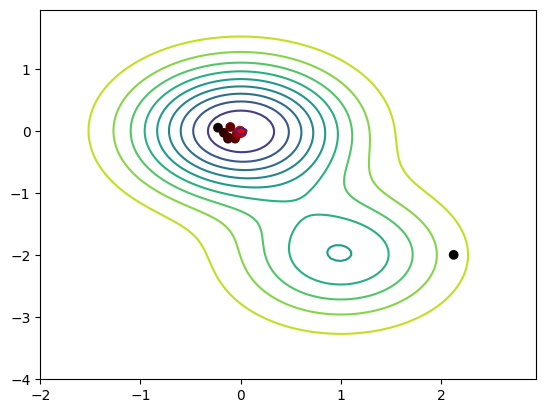

=== Test Run ===
Chromosome length: 20
Population size: 200
Tournament size: 2
Mutation probability: 0.05
Crossover probability: 0.8
Generations: 50
Best decoded solution (x,y): (0.0029325513196480912, -0.008797653958944274)
Best value: 0.496576



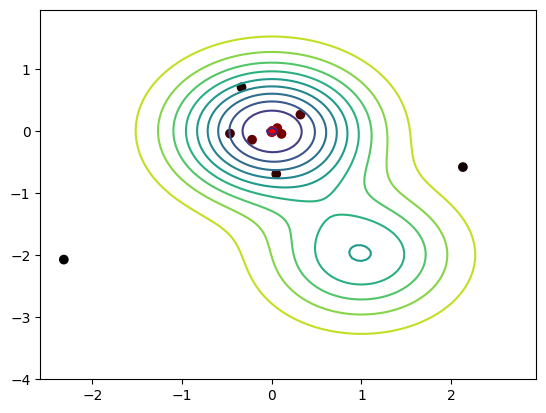

=== Test Run ===
Chromosome length: 20
Population size: 500
Tournament size: 2
Mutation probability: 0.05
Crossover probability: 0.8
Generations: 50
Best decoded solution (x,y): (0.0029325513196480912, -0.008797653958944274)
Best value: 0.496576



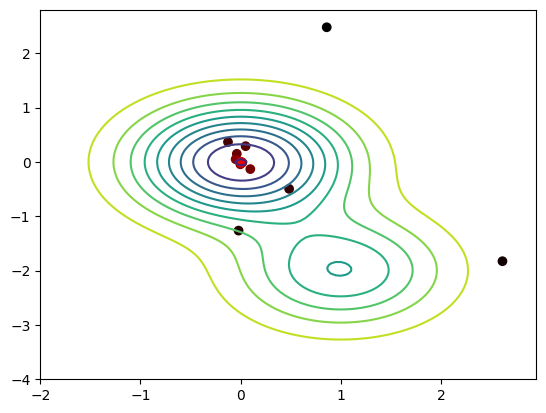

=== Test Run ===
Chromosome length: 20
Population size: 1000
Tournament size: 2
Mutation probability: 0.05
Crossover probability: 0.8
Generations: 50
Best decoded solution (x,y): (0.0029325513196480912, -0.008797653958944274)
Best value: 0.496576



In [36]:
for pop_size in [50, 100, 200, 500, 1000]:
    run_test(chromosome_length=20, population_size=pop_size, tournament_size=2,
             mutation_probability=0.05, crossover_probability=0.8, num_steps=50)


### 🔬 Experiment 3: Tournament Size

Tournament size controls **selection pressure**:
- Small tournament (e.g. 2) = more randomness, higher diversity,  
- Large tournament (e.g. 5+) = stronger pressure, may converge faster but risk getting stuck.


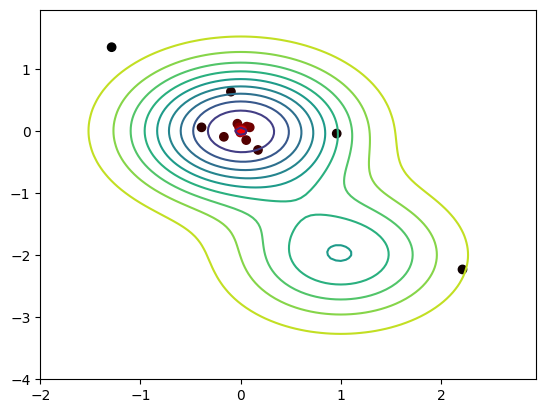

=== Test Run ===
Chromosome length: 20
Population size: 200
Tournament size: 2
Mutation probability: 0.05
Crossover probability: 0.8
Generations: 50
Best decoded solution (x,y): (0.0029325513196480912, -0.008797653958944274)
Best value: 0.496576



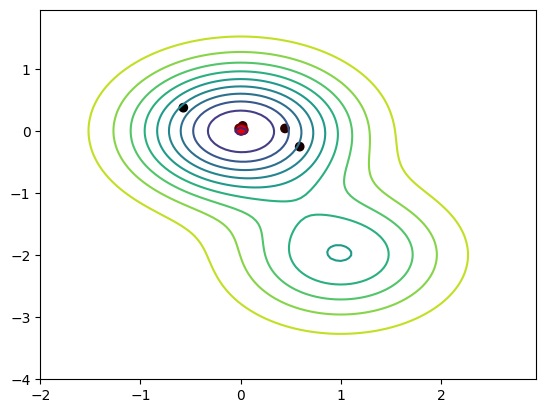

=== Test Run ===
Chromosome length: 20
Population size: 200
Tournament size: 3
Mutation probability: 0.05
Crossover probability: 0.8
Generations: 50
Best decoded solution (x,y): (0.0029325513196480912, 0.0029325513196480912)
Best value: 0.496668



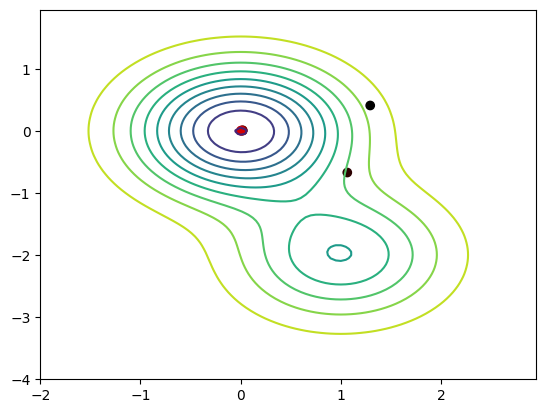

=== Test Run ===
Chromosome length: 20
Population size: 200
Tournament size: 5
Mutation probability: 0.05
Crossover probability: 0.8
Generations: 50
Best decoded solution (x,y): (0.0029325513196480912, 0.0029325513196480912)
Best value: 0.496668



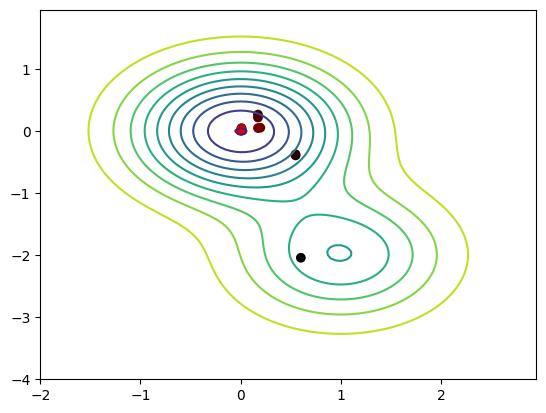

=== Test Run ===
Chromosome length: 20
Population size: 200
Tournament size: 10
Mutation probability: 0.05
Crossover probability: 0.8
Generations: 50
Best decoded solution (x,y): (0.0029325513196480912, 0.0029325513196480912)
Best value: 0.496668



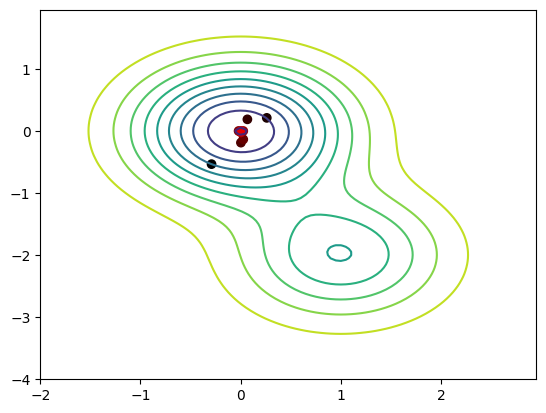

=== Test Run ===
Chromosome length: 20
Population size: 200
Tournament size: 50
Mutation probability: 0.05
Crossover probability: 0.8
Generations: 50
Best decoded solution (x,y): (0.0029325513196480912, -0.008797653958944274)
Best value: 0.496576



In [37]:
for t_size in [2, 3, 5, 10, 50]:
    run_test(chromosome_length=20, population_size=200, tournament_size=t_size,
             mutation_probability=0.05, crossover_probability=0.8, num_steps=50)


### 🔬 Experiment 4: Mutation Probability

Mutation controls **exploration**:
- Low mutation = fine-tuning,  
- High mutation = more randomness, helps escape local minima.


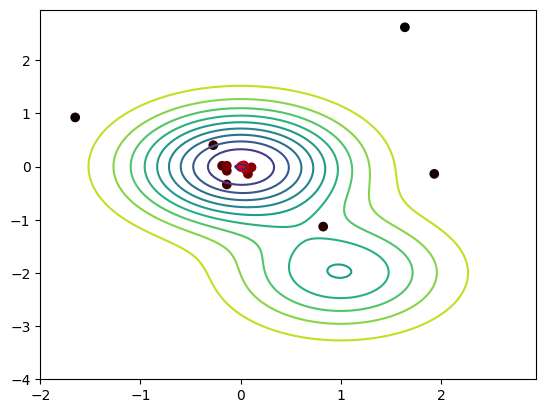

=== Test Run ===
Chromosome length: 20
Population size: 200
Tournament size: 2
Mutation probability: 0.01
Crossover probability: 0.8
Generations: 50
Best decoded solution (x,y): (0.0029325513196480912, -0.008797653958944274)
Best value: 0.496576



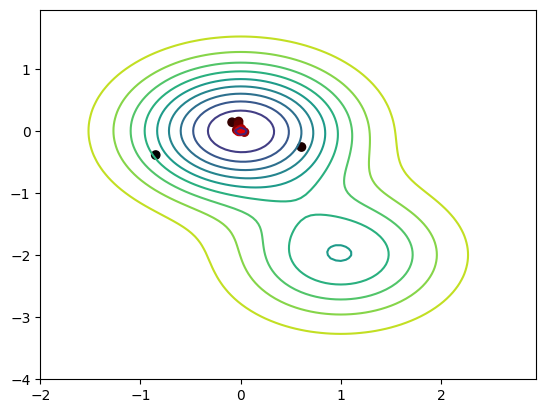

=== Test Run ===
Chromosome length: 20
Population size: 200
Tournament size: 2
Mutation probability: 0.05
Crossover probability: 0.8
Generations: 50
Best decoded solution (x,y): (-0.0029325513196480912, -0.008797653958944274)
Best value: 0.496617



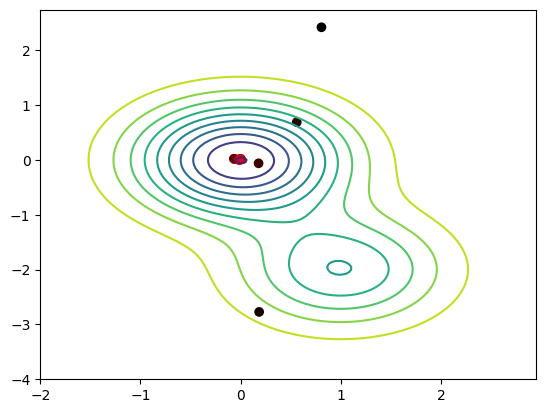

=== Test Run ===
Chromosome length: 20
Population size: 200
Tournament size: 2
Mutation probability: 0.1
Crossover probability: 0.8
Generations: 50
Best decoded solution (x,y): (-0.0029325513196480912, 0.0029325513196480912)
Best value: 0.496707



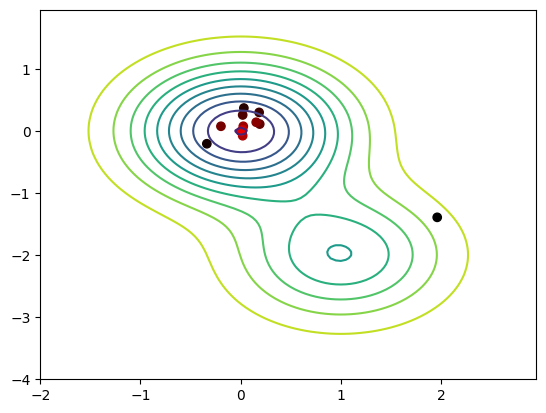

=== Test Run ===
Chromosome length: 20
Population size: 200
Tournament size: 2
Mutation probability: 0.2
Crossover probability: 0.8
Generations: 50
Best decoded solution (x,y): (0.0029325513196480912, -0.008797653958944274)
Best value: 0.496576



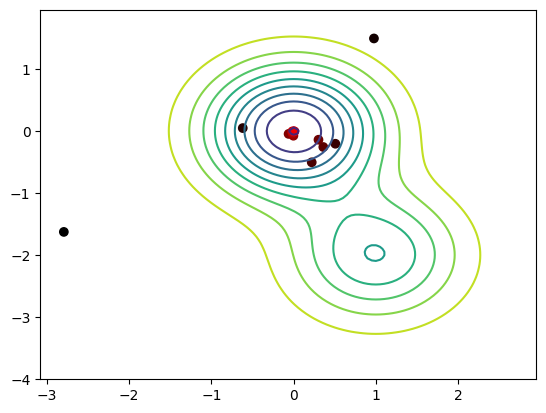

=== Test Run ===
Chromosome length: 20
Population size: 200
Tournament size: 2
Mutation probability: 0.7
Crossover probability: 0.8
Generations: 50
Best decoded solution (x,y): (0.0029325513196480912, -0.008797653958944274)
Best value: 0.496576



In [38]:
for mut_prob in [0.01, 0.05, 0.1, 0.2, 0.7]:
    run_test(chromosome_length=20, population_size=200, tournament_size=2,
             mutation_probability=mut_prob, crossover_probability=0.8, num_steps=50)


### 🔬 Experiment 5: Crossover Probability

Crossover probability controls **recombination of solutions**:
- Low crossover = offspring often copy parents directly,  
- High crossover = more mixing of genetic material, faster exploration.


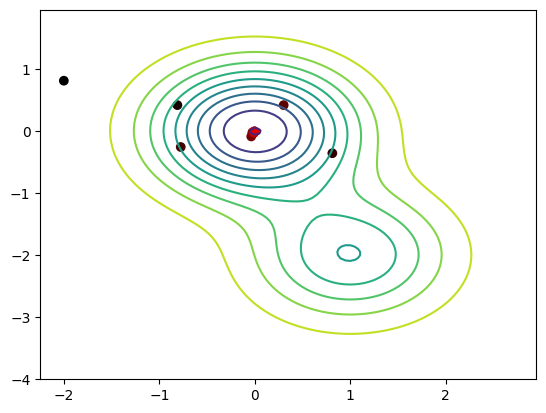

=== Test Run ===
Chromosome length: 20
Population size: 200
Tournament size: 2
Mutation probability: 0.05
Crossover probability: 0.1
Generations: 50
Best decoded solution (x,y): (-0.0029325513196480912, -0.008797653958944274)
Best value: 0.496617



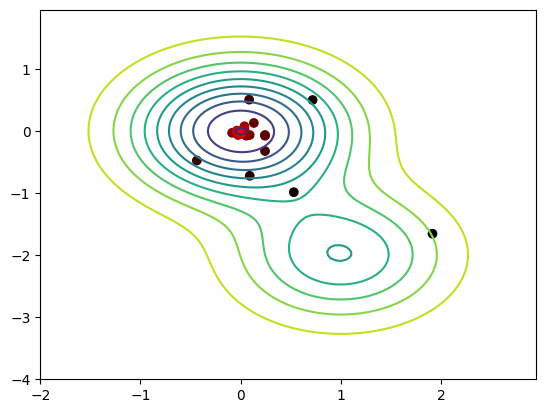

=== Test Run ===
Chromosome length: 20
Population size: 200
Tournament size: 2
Mutation probability: 0.05
Crossover probability: 0.6
Generations: 50
Best decoded solution (x,y): (0.0029325513196480912, -0.008797653958944274)
Best value: 0.496576



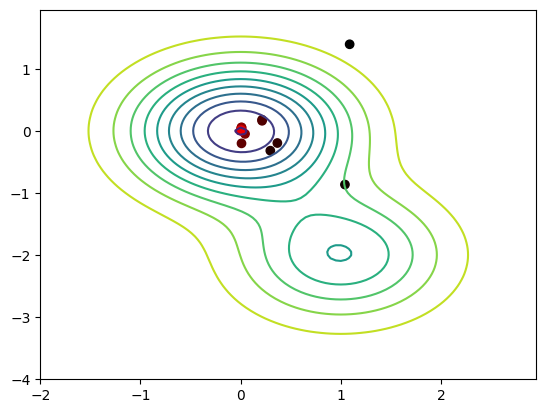

=== Test Run ===
Chromosome length: 20
Population size: 200
Tournament size: 2
Mutation probability: 0.05
Crossover probability: 0.8
Generations: 50
Best decoded solution (x,y): (0.0029325513196480912, 0.0029325513196480912)
Best value: 0.496668



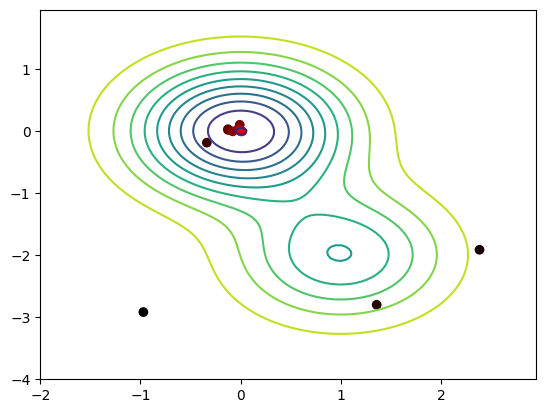

=== Test Run ===
Chromosome length: 20
Population size: 200
Tournament size: 2
Mutation probability: 0.05
Crossover probability: 0.9
Generations: 50
Best decoded solution (x,y): (0.0029325513196480912, -0.008797653958944274)
Best value: 0.496576



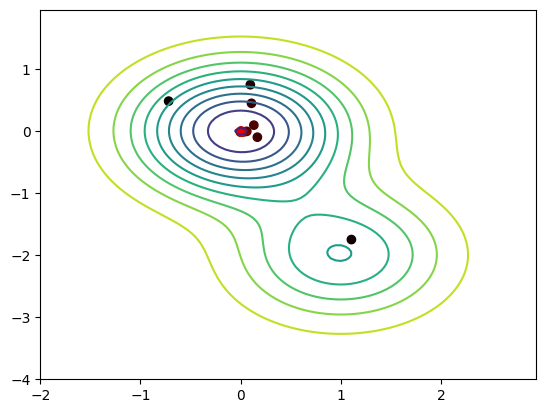

=== Test Run ===
Chromosome length: 20
Population size: 200
Tournament size: 2
Mutation probability: 0.05
Crossover probability: 0.95
Generations: 50
Best decoded solution (x,y): (0.0029325513196480912, -0.008797653958944274)
Best value: 0.496576



In [39]:
for cross_prob in [0.1, 0.6, 0.8, 0.9, 0.95]:
    run_test(chromosome_length=20, population_size=200, tournament_size=2,
             mutation_probability=0.05, crossover_probability=cross_prob, num_steps=50)


### 🔬 Experiment 6: Number of Generations

The number of generations (`num_steps`) determines **how long the GA runs**:
- Few generations = faster runtime, may stop before reaching good solution,  
- Many generations = more refinement, higher chance to find global minimum.


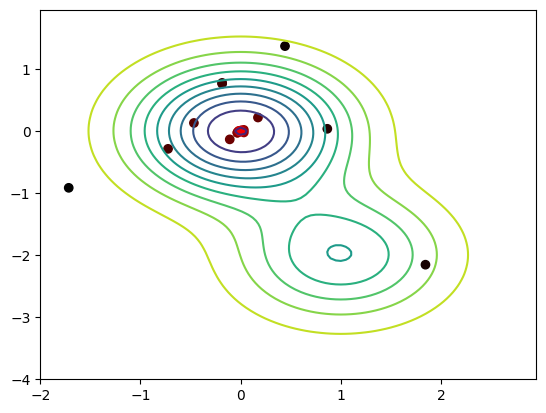

=== Test Run ===
Chromosome length: 20
Population size: 200
Tournament size: 2
Mutation probability: 0.05
Crossover probability: 0.8
Generations: 20
Best decoded solution (x,y): (0.0029325513196480912, -0.008797653958944274)
Best value: 0.496576



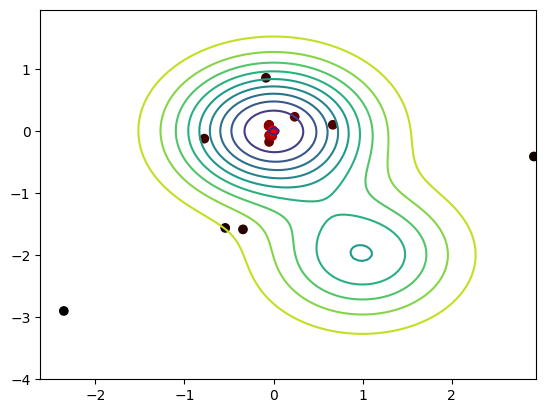

=== Test Run ===
Chromosome length: 20
Population size: 200
Tournament size: 2
Mutation probability: 0.05
Crossover probability: 0.8
Generations: 50
Best decoded solution (x,y): (-0.0029325513196480912, -0.008797653958944274)
Best value: 0.496617



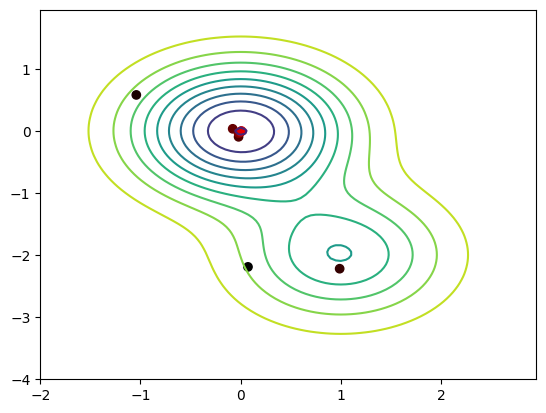

=== Test Run ===
Chromosome length: 20
Population size: 200
Tournament size: 2
Mutation probability: 0.05
Crossover probability: 0.8
Generations: 100
Best decoded solution (x,y): (0.0029325513196480912, -0.008797653958944274)
Best value: 0.496576



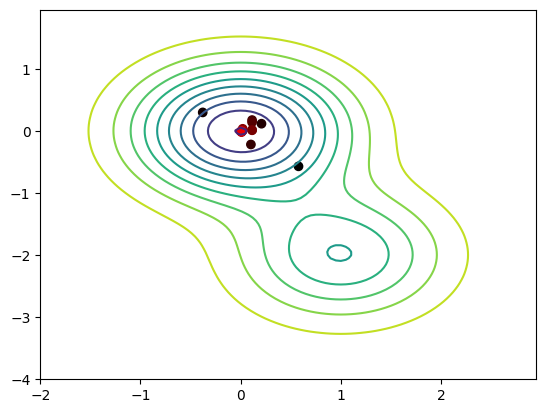

=== Test Run ===
Chromosome length: 20
Population size: 200
Tournament size: 2
Mutation probability: 0.05
Crossover probability: 0.8
Generations: 200
Best decoded solution (x,y): (0.0029325513196480912, -0.008797653958944274)
Best value: 0.496576



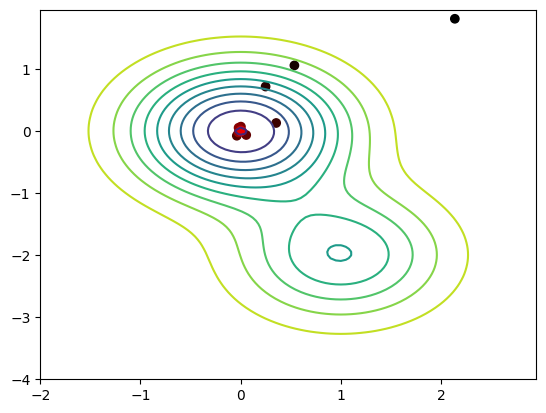

=== Test Run ===
Chromosome length: 20
Population size: 200
Tournament size: 2
Mutation probability: 0.05
Crossover probability: 0.8
Generations: 500
Best decoded solution (x,y): (0.0029325513196480912, -0.008797653958944274)
Best value: 0.496576



In [40]:
for steps in [20, 50, 100, 200, 500]:
    run_test(chromosome_length=20, population_size=200, tournament_size=2,
             mutation_probability=0.05, crossover_probability=0.8, num_steps=steps)
